## IMPORT LIBRARIES

In [3]:
pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.2 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import os
import scipy.io
import scipy.signal
import mne
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import time
from functools import partial
import torch
from torch.utils.data import DataLoader, Dataset, random_split

## SIGNAL EXTRACTION

In [ ]:
import pandas as pd
import numpy as np
import time
import pickle

root_path = '/content/drive/MyDrive/'
file_path_openneuro = 'EEG/'
file_path = root_path + file_path_openneuro

start = time.time()
ls = SignalExtraction.read_mne_iterator(file_path, None)
end = time.time()
print(f"Data extraction time: {end - start}")

# Save the data to a pickle file
with open('extracted_signals.pkl', 'wb') as f:
    pickle.dump(ls, f)

## SIGNAL PROCESSING

In [ ]:
import numpy as np
import pickle
from signal_processing import SignalProcessing
import time

# Load extracted signals from the pickle file
with open('extracted_signals.pkl', 'rb') as f:
    ls = pickle.load(f)

sliceSize = 6
bandFreqRange = [40, 100]
downsampleFreq = 200
subSliceSize = 2
sampleFrequency = 500

start = time.time()
training_data, error_data = SignalProcessing.signal_processing_iterator(ls, sampleFrequency, bandFreqRange, downsampleFreq, sliceSize, subSliceSize)
end = time.time()
print(f"Signal processing time: {end - start}")

print(f"Number of training data samples: {len(training_data)}")

# Save processed data for further preparation
with open('processed_signals.pkl', 'wb') as f:
    pickle.dump(training_data, f)

with open('error_signals.pkl', 'wb') as f:
    pickle.dump(error_data, f)


## SIGNAL PROCESSING VISUALIZATION

Reading /content/drive/MyDrive/EEG/sub-001/eeg/sub-001_task-Rest_run-01_eeg.fdt
Reading 0 ... 250733  =      0.000 ...   501.466 secs...
<RawEEGLAB | sub-001_task-Rest_run-01_eeg.fdt, 66 x 250734 (501.5 s), ~126.3 MB, data loaded>
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


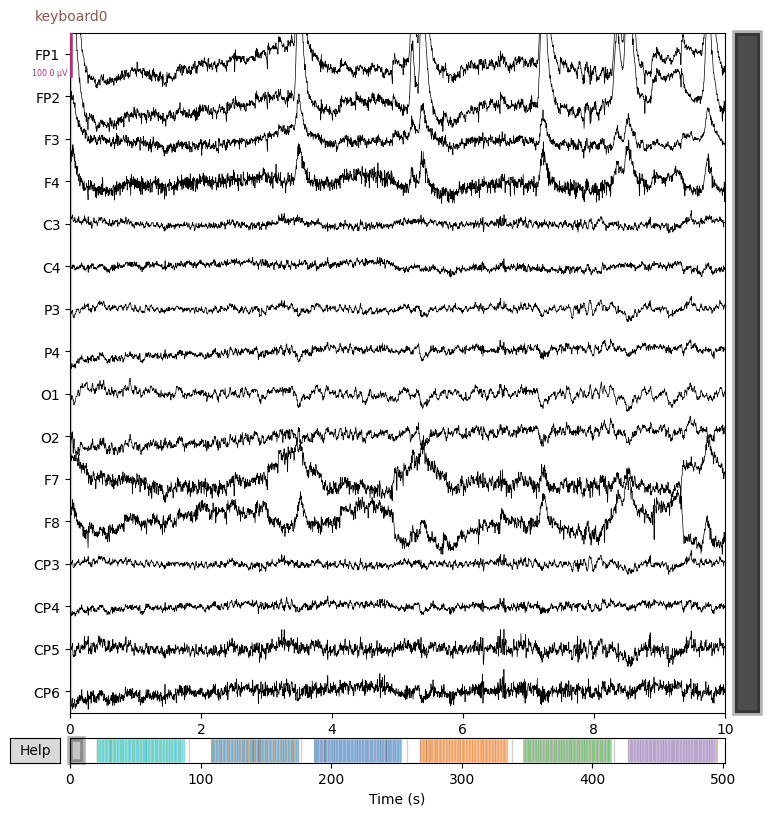

In [13]:
import mne
import matplotlib.pyplot as plt

# Path to the .set file
set_file_path = "/content/drive/MyDrive/EEG/sub-001/eeg/sub-001_task-Rest_run-01_eeg.set"

# Load the data
raw = mne.io.read_raw_eeglab(set_file_path, preload=True)

# Print some basic information about the data
print(raw)

# Specify the channels you want to visualize
channels_to_plot = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'CP3', 'CP4', 'CP5', 'CP6']

# Pick only the specified channels
raw.pick_channels(channels_to_plot)

# Create a figure to plot the EEG data
fig = raw.plot(n_channels=len(channels_to_plot), duration=10, scalings=dict(eeg=50e-6), show=False)

# Save the figure in high resolution
fig.savefig("eeg_plot.png", dpi=600)

# Show the plot (optional)
plt.show()


Reading /content/drive/MyDrive/EEG/sub-001/eeg/sub-001_task-Rest_run-01_eeg.fdt
Reading 0 ... 250733  =      0.000 ...   501.466 secs...
Sample rate: 500 Hz
First few data points of FP1 channel: [0.00026751 0.00027322 0.00027616 0.00028821 0.00030779 0.00032191
 0.00032284 0.00031604 0.00031393 0.00032305]


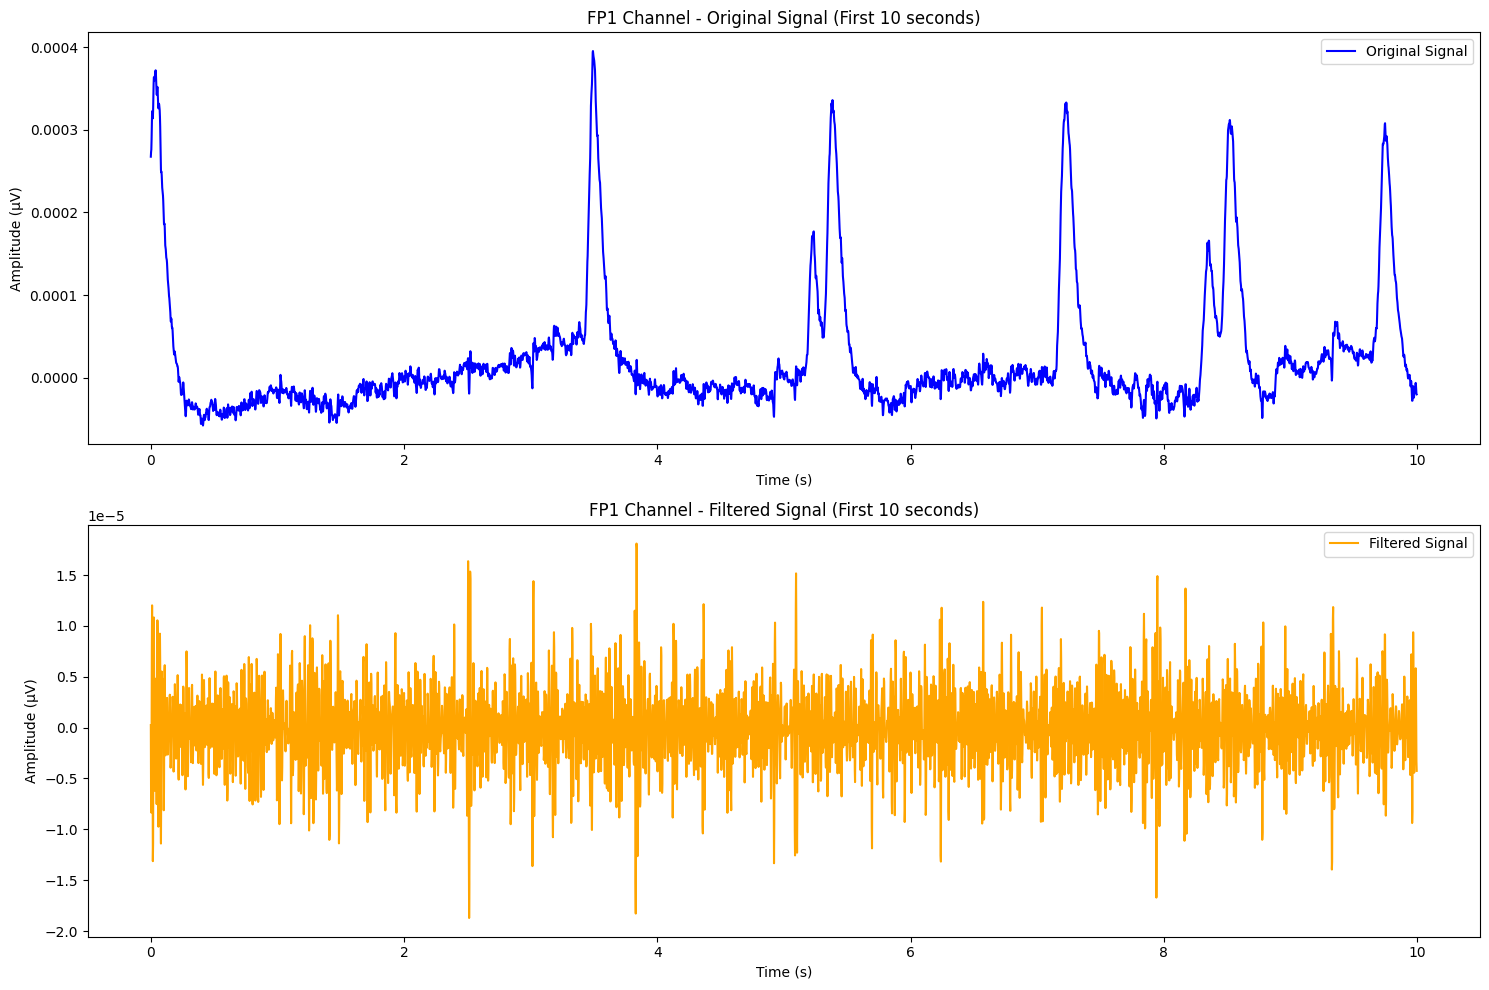

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from signal_processing import SignalProcessing

# Path to the .set file
set_file_path = "/content/drive/MyDrive/EEG/sub-001/eeg/sub-001_task-Rest_run-01_eeg.set"

# Load the data
raw = mne.io.read_raw_eeglab(set_file_path, preload=True)

# Extract data for the 'FP1' channel
fp1_data = raw.get_data(picks=['FP1'])[0]
sample_rate = int(raw.info['sfreq'])  # Convert to integer

# Print the sample rate and first few data points to debug
print(f"Sample rate: {sample_rate} Hz")
print(f"First few data points of FP1 channel: {fp1_data[:10]}")

# Define bandpass filter parameters
edges = [40, 100]
poles = 4

# Apply the bandpass filter
filtered_fp1_data = SignalProcessing.bandpass_filter(edges, sample_rate, poles, fp1_data)

# Plot the original and filtered signals for a short duration (e.g., first 10 seconds)
time = np.arange(fp1_data.size) / sample_rate

plt.figure(figsize=(15, 10))

# Plot the original signal
plt.subplot(2, 1, 1)
plt.plot(time[:sample_rate * 10], fp1_data[:sample_rate * 10], label='Original Signal', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title('FP1 Channel - Original Signal (First 10 seconds)')
plt.legend()

# Plot the filtered signal
plt.subplot(2, 1, 2)
plt.plot(time[:sample_rate * 10], filtered_fp1_data[:sample_rate * 10], label='Filtered Signal', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title('FP1 Channel - Filtered Signal (First 10 seconds)')
plt.legend()

plt.tight_layout()
plt.savefig('fp1_channel_signals.png', dpi=600)
plt.show()


## DATA PREPARATION

In [ ]:
import numpy as np
import os
from training_data import TrainingData

# Load processed signals
training_data = np.load('processed_signals.npy', allow_pickle=True)

# Creating a folder to save processed data
output_folder = "processed_data"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Saving processed data for each subject
for subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label in training_data:
    subject_folder = os.path.join(output_folder, subject_id)
    if not os.path.exists(subject_folder):
        os.makedirs(subject_folder)

    # Save processed data in the subject's folder
    np.save(os.path.join(subject_folder, "signal_processed.npy"), signal_processed)
    np.save(os.path.join(subject_folder, "Adj_dist_matrix.npy"), Adj_dist_matrix)
    np.save(os.path.join(subject_folder, "bdi_label.npy"), bdi_label)

X = TrainingData.trainingData_iterator(training_data)

# Distribution of categorical Variable
ls = []
for i in X:
    signal_slice, Adj_dist_matrix, bdi_label = i
    ls.append(bdi_label)

print(len(ls), sum(ls), len(ls)-sum(ls))

dataSet = X
print(len(dataSet))

from torch.utils.data import DataLoader, random_split

def train_test_datasets(dataSet, batch_size, train_test_split):
    train_size = int(len(dataSet) * train_test_split)
    test_size = len(dataSet) - train_size
    train_dataset, test_dataset = random_split(dataSet, [train_size, test_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

batch_size = 40
train_test_split = 0.7

train_dataloader, test_dataloader = train_test_datasets(dataSet, batch_size, train_test_split)

print(len(train_dataloader), len(test_dataloader), len(train_dataloader.dataset) + len(test_dataloader.dataset), (len(train_dataloader)-1)*batch_size + len(test_dataloader))

signal, Adj_dist_matrix, label = dataSet[0]
print(signal.shape, Adj_dist_matrix.shape, label, len(dataSet))
